In [64]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import random

In [65]:
# Defining hyperparameters
TRAIN_BATCH_SIZE = 16
VAL_TEST_BATCH_SIZE = 32
LEARNING_RATE = .001
SEED = 42

# Setting the seed for reproducability
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(SEED)

# Creating variables to store numerical, categorical, and all feature names
numerical_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_vars = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease', 'FastingBS']
all_vars = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']

In [66]:
# Load the data
df_train_val = pd.read_parquet('data/train_val.parquet')
df_test = pd.read_parquet('data/test.parquet')

# Scaling the numerical variables with min-max scaler and creating numpy arrays from them
scaler = MinMaxScaler()

X_train_val = df_train_val.drop('HeartDisease', axis=1)
X_train_val[numerical_vars] = scaler.fit_transform(X_train_val[numerical_vars])
X_train_val = X_train_val.to_numpy()
X_test = df_test.drop('HeartDisease', axis=1)
X_test[numerical_vars] = scaler.transform(X_test[numerical_vars])
X_test = X_test.to_numpy()

# Getting the target values from the data frames
y_train_val = df_train_val['HeartDisease'].to_numpy()
y_test = df_test['HeartDisease'].to_numpy()

# Transforming the arrays to tensors
X_train_val = torch.from_numpy(X_train_val).float()
y_train_val = torch.from_numpy(y_train_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Splitting train_val set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.2, random_state=42, shuffle=True)

# Reshaping the outcomes to column vectors
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
#y_train_val = y_train_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Creating datasets from the tensors
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
#train_val_data = TensorDataset(X_train_val, y_train_val)
test_data = TensorDataset(X_test, y_test)

# Creating data loaders for the datasets
train_dataloader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=VAL_TEST_BATCH_SIZE, shuffle=False)
#train_val_dataloader = DataLoader(train_val_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=VAL_TEST_BATCH_SIZE, shuffle=False)

In [67]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    """
    Trains a model for one epoch.

    Parameters:
    -----------
    dataloader : torch.utils.data.DataLoader
        The DataLoader providing the training data in batches.
    model : torch.nn.Module
        The PyTorch model to be trained.
    loss_fn : callable
        The loss function used to compute the difference between predictions and targets.
    optimizer : torch.optim.Optimizer
        The optimizer used to update model weights.

    Returns:
    --------
    None
    """

    size = len(dataloader.dataset) # Total number of samples in the dataset

    # Set the model to training mode
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print progress every 10 batches
        if batch % 10 == 0:
            loss_value = loss.item()  # Convert tensor to scalar for logging
            current = batch * dataloader.batch_size + len(X)
            print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")


def evaluate_model(dataloader, model, loss_fn):
    """
    Evaluates a trained model on a given dataset.

    Parameters:
    -----------
    dataloader : torch.utils.data.DataLoader
        The DataLoader providing the evaluation data in batches.
    model : torch.nn.Module
        The PyTorch model to be evaluated.
    loss_fn : callable
        The loss function used to compute the loss between predictions and targets.

    Returns:
    --------
    loss : float
        Average loss over the dataset.
    f1 : float
        F1 score of the predictions.
    balanced_acc : float
        Balanced accuracy score of the predictions.
    """
    
    # Total number of samples and batches
    size = len(dataloader.dataset)
    num_batches = len(dataloader) 
    
    # Initialize tracking variables
    loss = 0
    correct = 0
    preds = []
    labels = []
    
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad(): # Disable gradient tracking for efficiency
        for X, y in dataloader:
            # Forward pass
            pred = model(X)

            # Accumulate loss
            loss += loss_fn(pred, y).item()

            # Apply sigmoid for binary classification, then round to 0 or 1
            pred = pred.sigmoid().round()

            # Count correct predictions
            correct += (pred == y).type(torch.float).sum().item()

            # Save predictions and true labels for metric computation
            preds.append(pred.cpu())
            labels.append(y.cpu())

    # Concatenate all batch predictions and labels
    preds = torch.cat(preds)              
    labels = torch.cat(labels)  
        
    # Compute average loss and accuracy
    loss /= num_batches
    correct /= size

    # Compute additional metrics
    f1 = f1_score(labels, preds)
    balanced_acc = balanced_accuracy_score(labels, preds)
    
    # Print summary of evaluation metrics
    print(f"Test Error: \n Accuracy: {(100*correct):.2f}%, \n Avg loss: {loss:.4f}, \n f1 score: {f1:.4f} \n Balanced accuracy: {balanced_acc:.4f} \n")
    
    return loss, f1, balanced_acc

In [117]:
# Small neural network for modeling individual features
class FeatureNet(nn.Module):
    """
    A simple feedforward neural network that models a single feature independently.
    
    Architecture:
    -------------
    Input: 1-dimensional feature
    Layers:
        - Linear(1 → 16) + ReLU
        - Linear(16 → 16) + ReLU
        - Linear(16 → 1)
    
    Purpose:
    --------
    Used as a building block for the NAM model, where each feature is passed through
    its own independent network.
    """
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),   # Project scalar input to hidden dimension
            nn.ReLU(),          # Non-linearity
            nn.Linear(16, 16),  # Further transformation
            nn.ReLU(),          
            nn.Linear(16, 1),   # Reduce back to scalar output
        )

    def forward(self, x):
        """
        Forward pass through the feature network.

        Parameters:
        -----------
        x : torch.Tensor
            Tensor of shape (batch_size, 1) representing a single feature.

        Returns:
        --------
        torch.Tensor
            Output of shape (batch_size, 1)
        """
        return self.net(x)

# Neural Additive Model (NAM)
class NAM(nn.Module):
    """
    Neural Additive Model (NAM).
    
    Description:
    ------------
    A model that applies a separate neural network (FeatureNet) to each input feature
    independently and then sums their outputs. This encourages interpretability 
    similar to Generalized Additive Models (GAMs) while leveraging neural networks.

    Parameters:
    -----------
    num_features : int
        The number of input features. A separate FeatureNet will be created for each.

    Forward Input:
    --------------
    x : torch.Tensor
        Input tensor of shape (batch_size, num_features)

    Forward Output:
    ---------------
    torch.Tensor
        Output tensor of shape (batch_size, 1)
    """
    def __init__(self, num_features):
        super().__init__()
        # Create one FeatureNet for each input feature
        self.feature_nets = nn.ModuleList([
            FeatureNet()
            for _ in range(num_features)
        ])

    def forward(self, x):
        """
        Forward pass through the NAM.

        Each feature column is passed through its own FeatureNet,
        and the outputs are summed across all features.

        Parameters:
        -----------
        x : torch.Tensor
            Input tensor of shape (batch_size, num_features)

        Returns:
        --------
        torch.Tensor
            Output tensor of shape (batch_size, 1)
        """
        # Apply each FeatureNet to its corresponding feature column
        outputs = [net(x[:, i:i+1]) for i, net in enumerate(self.feature_nets)]
        
        # Stack along a new dimension → (batch_size, num_features, 1),
        # then sum across features → (batch_size, 1)
        out = torch.stack(outputs, dim=1).sum(dim=1)
        
        return out


Epoch 1
-------------------------------
loss: 0.799144  [   16/  587]
loss: 0.728090  [  176/  587]
loss: 0.605164  [  336/  587]
loss: 0.666607  [  496/  587]
Test Error: 
 Accuracy: 80.95%, 
 Avg loss: 0.6247, 
 f1 score: 0.8205 
 Balanced accuracy: 0.8084 

Epoch 2
-------------------------------
loss: 0.644889  [   16/  587]
loss: 0.692035  [  176/  587]
loss: 0.610294  [  336/  587]
loss: 0.560050  [  496/  587]
Test Error: 
 Accuracy: 81.63%, 
 Avg loss: 0.5467, 
 f1 score: 0.8457 
 Balanced accuracy: 0.8108 

Epoch 3
-------------------------------
loss: 0.520427  [   16/  587]
loss: 0.507421  [  176/  587]
loss: 0.394769  [  336/  587]
loss: 0.458507  [  496/  587]
Test Error: 
 Accuracy: 85.03%, 
 Avg loss: 0.4702, 
 f1 score: 0.8659 
 Balanced accuracy: 0.8474 

Epoch 4
-------------------------------
loss: 0.506855  [   16/  587]
loss: 0.428453  [  176/  587]
loss: 0.571699  [  336/  587]
loss: 0.559811  [  496/  587]
Test Error: 
 Accuracy: 84.35%, 
 Avg loss: 0.4331, 
 f1 

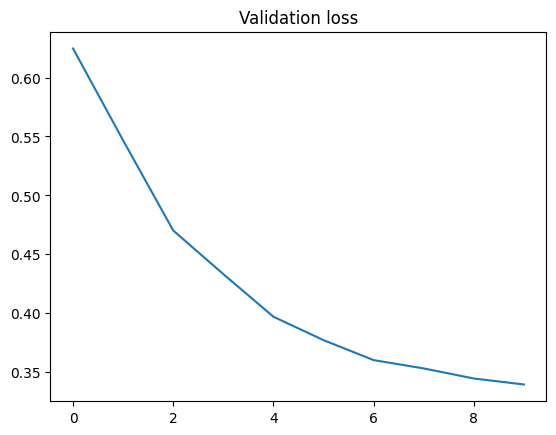

In [122]:
#model = NAM(11, hidden_num=2, hidden_dim=32)
model = NAM(11)
loss_fn = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

losses = []
for epoch in range(10):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_one_epoch(train_dataloader, model, loss_fn, optimizer)
    loss, _, _ = evaluate_model(val_dataloader, model, loss_fn)
    losses.append(loss)

print("Done!")

plt.plot(losses)
plt.title("Validation loss")
plt.show()

In [123]:
# Evaluating the model on the test set and sacing the loss, the f1 score and the balanced accuracy metrics
model.eval()
loss, f1, balanced_acc = evaluate_model(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 84.24%, 
 Avg loss: 0.3941, 
 f1 score: 0.8711 
 Balanced accuracy: 0.8306 



# Saving the model and the test metrics (commented out)

In [ ]:
# Saving the model parameters
#torch.save(model.state_dict(), "./trained_models/NAM.pth")

# Saving the results as a data frame
#output_df = pd.DataFrame({"Model": ["NAM"], "Test f1-score": [f1], "Test balanced accuracy": [balanced_acc]})
#output_df.to_parquet("./results/NAM")
#output_df

,Model,Test f1-score,Test balanced accuracy
0,NAM,0.871111,0.83059


# Visualizing the model

In [125]:
def visualize_feature(model, feature_index, feature_name, ax, num_categories=None, x_range=(0, 1), num_points=100):
    """
    Visualizes the learned contribution function of a single feature from a NAM model.

    Parameters:
    -----------
    model : NAM
        A trained Neural Additive Model containing per-feature sub-networks.
    feature_index : int
        Index of the feature to visualize (used to select the corresponding FeatureNet).
    feature_name : str
        Name of the feature (used for labeling the plot and determining scaling).
    ax : matplotlib.axes.Axes
        Matplotlib Axes object where the plot will be drawn.
    num_categories : int or None, optional
        If the feature is categorical, specify the number of categories. If None, the feature is assumed to be numerical.
    x_range : tuple of float, optional
        Range of values to evaluate the contribution function over (in normalized scale).
    num_points : int, optional
        Number of points to sample for plotting the numerical feature contribution curve.

    Returns:
    --------
    None
    """
    # Get the specific sub-network for the selected feature
    net = model.feature_nets[feature_index]

    with torch.no_grad():  # Disable gradient tracking for evaluation
        if num_categories is None:
            # Feature is numerical

            # Find original data scale using the global scaler and feature name
            numerical_index = numerical_vars.index(feature_name)
            data_min = scaler.data_min_[numerical_index]
            data_max = scaler.data_max_[numerical_index]

            # Create normalized input range
            x_vals = torch.linspace(*x_range, steps=num_points).unsqueeze(1)

            # Get contribution from the feature's neural net
            y_vals = net(x_vals).squeeze()

            # Rescale x_vals to original feature scale
            x_vals_original = x_vals * (data_max - data_min) + data_min

            # Plot the curve
            ax.plot(x_vals_original.numpy(), y_vals.numpy())

        else:
            # Feature is categorical

            # Generate integer category values (0 to num_categories - 1)
            x_vals = torch.arange(num_categories).float().view(-1, 1)

            # Get contributions for each category
            y_vals = net(x_vals).squeeze().numpy()

            # Plot as bar chart
            ax.bar(x_vals.squeeze().numpy(), y_vals)
            # Optionally set custom tick labels here if needed

        # Set axis titles and labels
        ax.set_title(feature_name)
        ax.set_xlabel(feature_name)
        ax.set_ylabel(f"{feature_name} contribution")

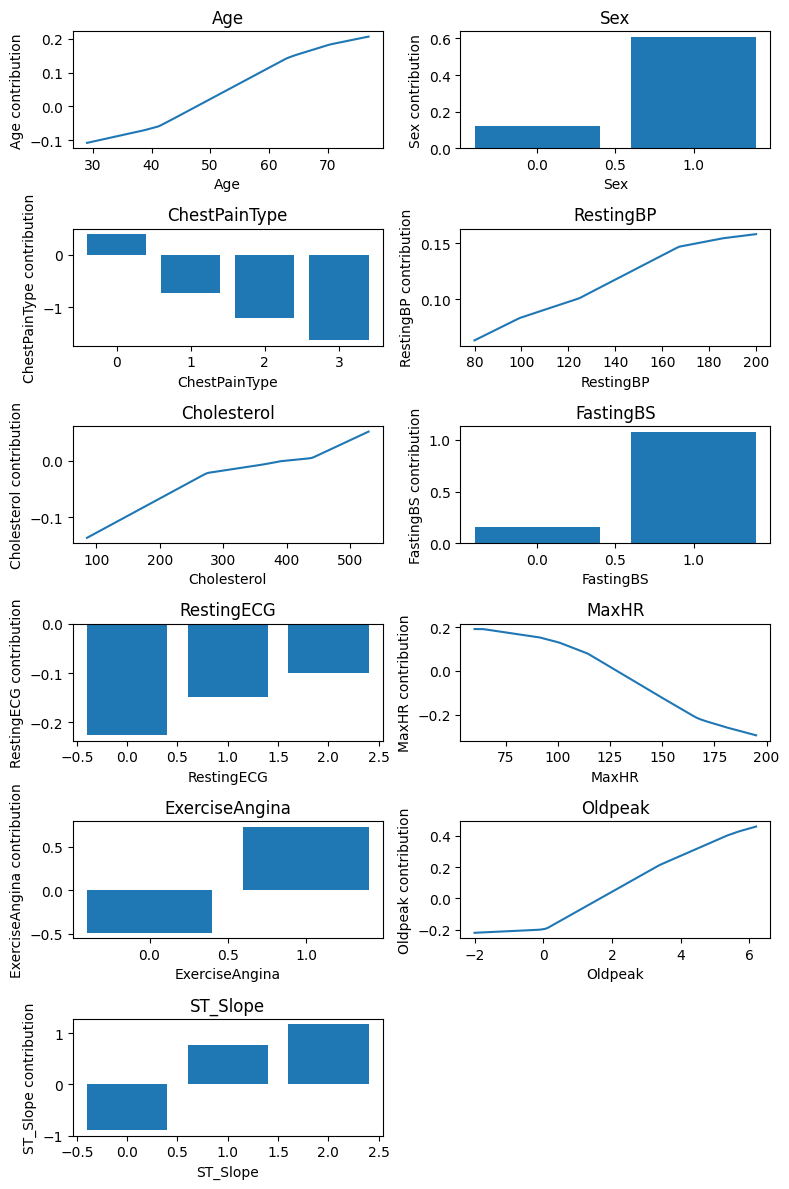

In [127]:
# Visualize the learned contributions of the features
fig, axs = plt.subplots(6, 2, figsize=(8, 12))
for k, var in enumerate(all_vars):
    i = int(k / 2)
    j = int(k - i*2) % 2
    num_categories = None
    if var in categorical_vars:
        num_categories = len(df_test[var].unique())
    visualize_feature(model, k, var, axs[i, j], num_categories=num_categories)

axs[5, 1].set_visible(False)
plt.tight_layout()
plt.show()